# model_rnx

**Author:** Marilyn Braojos Gutierrez\
**Purpose:** This program aims to calculate the clock bias obtained from the parameters extracted from local RINEX files with GPS satellite broadcast information for 30S intervals.\
**PhD Milestone:** #1: *Leverage deep learning models to GPS satellite clock bias corrections.*\
**Project:** This program is Step (1) in this PhD milestone. Obtaining the data is the first critical step.\
**References:**\
[1] https://www.gps.gov/technical/icwg/IS-GPS-200N.pdf

# Import Libraries

In [1]:
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os

# Compute Polynomial for 30S Intervals

In [2]:
# calculate the start of the week (Sunday at 12:00 AM UTC)

def start_of_week(t):
    
    # Find the weekday (0 = Monday, 6 = Sunday)
    weekday = t.weekday()
    
    # Calculate the start of the week
    start_of_week_dt = t - timedelta(days=(weekday + 1) % 7, hours=t.hour, minutes=t.minute, seconds=t.second, microseconds=t.microsecond)
    
    return start_of_week_dt

In [3]:
mu = 3.986005e14 # earth's gravitational constant [m^3/s^2]
c = 2.99792458e8
F = -2*np.sqrt(mu)/c**2
leap_sec = 18

In [4]:
def broadcast_poly(yr, d, satellite_name):
    try: 
        input_folder = "/Users/marilyn/Library/Mobile Documents/com~apple~CloudDocs/Documents/doctorate/ssdl/ssdl_glrg/gps_transformer/rnx_npz_sat"
        sat_name = f"{satellite_name}"
        
        sat_folder = os.path.join(input_folder, sat_name)
        
        input_filename = os.path.join(sat_folder, f'gps_rnx_{yr}{d}_{satellite_name}.npz')
        
        broadcast = np.load(input_filename)
        
        # Extract the arrays
        satellite = broadcast['satellite']
        yyyy = broadcast['yyyy']
        mm = broadcast['mm']
        dd = broadcast['dd']
        hh = broadcast['hh']
        mi = broadcast['mi']
        ss = broadcast['ss']
        coeff_clock_bias = broadcast['clock_bias_coefficients']
        coeff_clock_bias_drift = broadcast['clock_bias_drift_coefficients']
        coeff_clock_bias_drift_rate = broadcast['clock_bias_drift_rate_coefficients']
        mean_motion_diff = broadcast['diff_mean_motion'] 
        mean_anomaly_0 = broadcast['ref_mean_anomaly'] 
        ecc = broadcast['eccen'] 
        sqrt_semi_major = broadcast['sqrt_semi'] 
        t_oe = broadcast['t_eph']
        health = broadcast['health_sv']
         
        # Combine date and time into datetime objects
        epochs = [datetime(year, month, day, hour, minute, second)
                  for year, month, day, hour, minute, second 
                  in zip(yyyy, mm, dd, hh, mi, ss)]
        
        # Calculate time differences in seconds
        time_differences = [(epochs[i+1] - epochs[i]).total_seconds() for i in range(len(epochs)-1)]
        
        for i in range(len(epochs)-1):
            if health[i] == 0: 
                    dt = 0
                    while dt <= time_differences[i]: ## iffy 
                        if dt > 7200: # only use parameters for 2 hours, otherwise move on to next epoch
                            break
                        
                        t_gps = epochs[i] + timedelta(seconds=dt)
                        start_of_week_t = start_of_week(t_gps)
                        t = (t_gps - start_of_week_t).total_seconds() + leap_sec
                        t_k = t - t_oe[i]
        
                        if t_k > 302400:
                            t_k -= 604800
                        elif t_k < -302400:
                            t_k += 604800
                        
                        A = sqrt_semi_major[i]**2
        
                        n_0 = np.sqrt(mu/(A**3))
        
                        n = n_0 + mean_motion_diff[i]
        
                        M_k = mean_anomaly_0[i] + (n*t_k)
        
        
                        # Eccentric anomaly 
                        
                        E_0 = M_k 
                        E_1 = E_0 + ((M_k - E_0 + ecc[i] * np.sin(E_0)) / (1 - ecc[i] * np.cos(E_0))) 
                        E_2 = E_1 + ((M_k - E_1 + ecc[i] * np.sin(E_1)) / (1 - ecc[i] * np.cos(E_1))) 
                        E_3 = E_2 + ((M_k - E_2 + ecc[i] * np.sin(E_2)) / (1 - ecc[i] * np.cos(E_2))) 
                        E_4 = E_3 + ((M_k - E_3 + ecc[i] * np.sin(E_3)) / (1 - ecc[i] * np.cos(E_3))) 
        
                        E_k = E_4
        
                        dT_r = F*ecc[i]*sqrt_semi_major[i]*np.sin(E_k)
                        
                        poly_value = (coeff_clock_bias[i] + 
                                      coeff_clock_bias_drift[i] * dt + 
                                      coeff_clock_bias_drift_rate[i] * dt**2 
                                      # +  dT_r
                                     )
        
                        poly_values.append(poly_value)
                        cumu_poly_values.append(poly_value)

                        time_strings.append((epochs[i] + timedelta(seconds=dt)).strftime('%Y:%m:%d:%H:%M:%S'))
                        cumu_time_strings.append((epochs[i] + timedelta(seconds=dt)).strftime('%Y:%m:%d:%H:%M:%S'))
                        
                        dt += 30 # time increments [s]
                
    except Exception as e:
        print(f"Error fetching data for day {d}: {e}")

In [5]:
%%time

days = range(1, 366)
days = [f'{day:03d}' for day in days]

years = range(2018,2019)

satellites = range(21, 22)

cumu_time_strings = []
cumu_poly_values = []

for yy in years: 
    for dd in days:
        for satellite_id in satellites:
            sat_id_str = f'G{satellite_id:02d}'
            
            time_strings = []
            poly_values = []
            broadcast_poly(yy, f"{dd}", sat_id_str)
        
            output_folder = "/Volumes/MARI/ssdl_gps/rnx_polynomial"
            os.makedirs(output_folder, exist_ok=True)
        
            output_filename = os.path.join(output_folder, f'gps_poly_{yy}{dd}_{sat_id_str}.npz')
            
            np.savez(output_filename, time_strings=time_strings, poly_values=poly_values)

            print(f'Done saving calculated broadcast clock bias from dT polynomial for day: {dd} of year: {yy} for satellite: {sat_id_str} with filename: {output_filename}')

Done saving calculated broadcast clock bias from dT polynomial for day: 001 of year: 2018 for satellite: G21 with filename: /Volumes/MARI/ssdl_gps/rnx_polynomial/gps_poly_2018001_G21.npz
Done saving calculated broadcast clock bias from dT polynomial for day: 002 of year: 2018 for satellite: G21 with filename: /Volumes/MARI/ssdl_gps/rnx_polynomial/gps_poly_2018002_G21.npz
Done saving calculated broadcast clock bias from dT polynomial for day: 003 of year: 2018 for satellite: G21 with filename: /Volumes/MARI/ssdl_gps/rnx_polynomial/gps_poly_2018003_G21.npz
Done saving calculated broadcast clock bias from dT polynomial for day: 004 of year: 2018 for satellite: G21 with filename: /Volumes/MARI/ssdl_gps/rnx_polynomial/gps_poly_2018004_G21.npz
Done saving calculated broadcast clock bias from dT polynomial for day: 005 of year: 2018 for satellite: G21 with filename: /Volumes/MARI/ssdl_gps/rnx_polynomial/gps_poly_2018005_G21.npz
Done saving calculated broadcast clock bias from dT polynomial fo

# Plot Polynomial

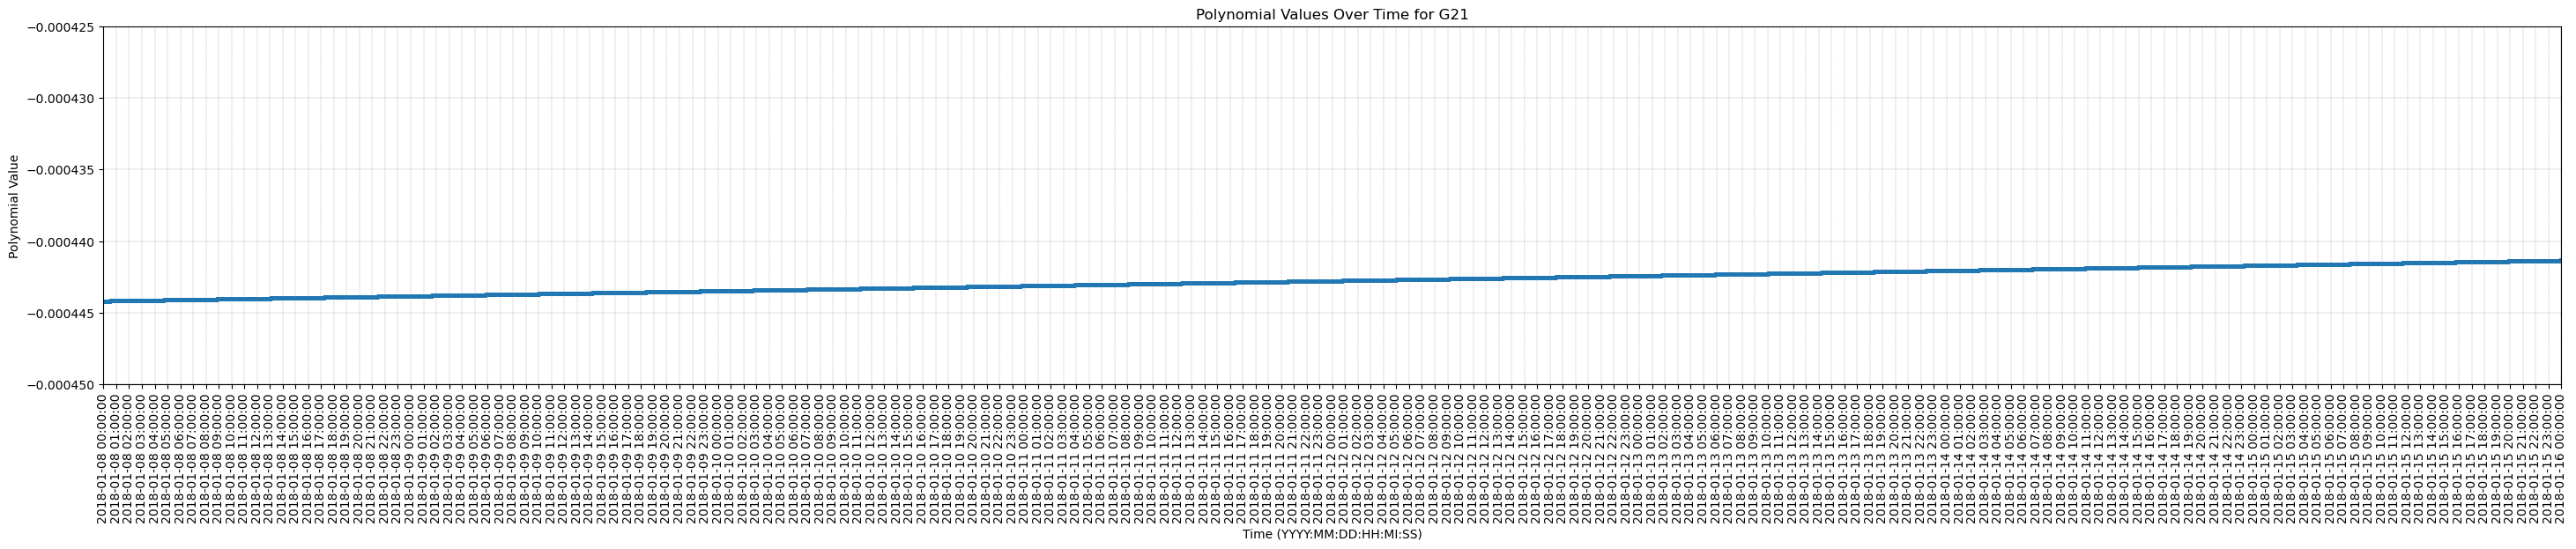

CPU times: user 12.3 s, sys: 152 ms, total: 12.4 s
Wall time: 11.9 s


In [8]:
%%time

# Convert time strings to datetime objects
cumu_time_datetimes = [datetime.strptime(cumu_ts, '%Y:%m:%d:%H:%M:%S') for cumu_ts in cumu_time_strings]
time_datetimes = [datetime.strptime(ts, '%Y:%m:%d:%H:%M:%S') for ts in time_strings]

# Plot the results
plt.figure(figsize=(30, 5))
plt.scatter(cumu_time_datetimes, cumu_poly_values, s = 5)
# plt.scatter(time_datetimes, poly_values)
plt.xlabel('Time (YYYY:MM:DD:HH:MI:SS)')
plt.ylabel('Polynomial Value')
plt.ylim(-0.000450, -0.000425)
e1 = datetime.strptime('2018:01:08:00:00:00', '%Y:%m:%d:%H:%M:%S')
e2 = datetime.strptime('2018:01:16:00:00:00', '%Y:%m:%d:%H:%M:%S')
plt.xlim(e1, e2)


plt.title('Polynomial Values Over Time for G21')

# # Format the x-axis to show dates correctly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Set major ticks every hour

plt.tight_layout()
plt.grid(color='gray', linestyle='--', linewidth=0.25)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# # Save time_strings and poly_values to an NPZ file
# # np.savez('time_poly_values.npz', time_strings=time_strings, poly_values=poly_values)

# poly = '/Volumes/MARI/ssdl_gps/rnx_polynomial/gps_poly_2019001_G21.npz'

# # Load the saved NPZ file to verify the data
# loaded_data = np.load(poly)
# loaded_time_strings = loaded_data['time_strings']
# loaded_poly_values = loaded_data['poly_values']

# # Verify the data
# print(len(loaded_time_strings))
# print(len(loaded_poly_values))
